In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import os
import time
import pylab as pl
from scipy.stats import multivariate_normal
from PIL import Image
import glob
from os import listdir
from PIL import Image as PImage
import imageio
import imutils
from imutils import contours

In [2]:
#Generate data
def image_points():
    #creat a list to store pixel intensities
    image_pixels = []
    #read the trained images from the train folder
    for image_path in glob.glob("buoy_Yellow\\Train\\*.png"):
        img = imageio.imread(image_path)
        #read pixels from green and red channel
        image_1 = img[:,:,1].ravel()
        image_2 = img[:,:,0].ravel()
        image = np.concatenate((image_1,image_2),axis=0)
        #combine the two channels and reshape it 1 channel
        image = np.reshape(image,(image.shape[0],1))
        r, c = image.shape
        for j in range(0, r):
            for m in range(0, c):
                im = image[j][m]
                image_pixels.append(im)
    image_pixels = np.array(image_pixels)
    #reshape it to 1-D array
    data  = np.reshape(image_pixels,(len(image_pixels),1))
    return data

In [3]:
data = image_points()
K = 2
data.shape

(29278, 1)

In [4]:
#generate initial parameters
def initial_parameters(data,K):    
    row,col = data.shape
    #initialize mean values reandomly from the distribution
    mean = np.array(data[np.random.choice(row,K)],np.float64)
    #initialize an identity matrix
    covar = [np.random.randint(1,255)*np.eye(col)]*K
    for sig in range(K):
        covar[sig]=np.multiply(covar[sig],np.random.rand(col,col))
    #initialize prior probablities equally such that sum is 1
    weights = [1./K]*K
    return mean,covar,weights
mean,covar,weights = initial_parameters(data,K)

print("initial mean=",mean)
print("initial covar=",covar)
print("initial weights=",weights)

initial mean= [[205.]
 [240.]]
initial covar= [array([[205.81858423]]), array([[80.13080465]])]
initial weights= [0.5, 0.5]


In [5]:
def train_GMM(data,K,mean,covar,weights):
    row,col = data.shape
    likelihood_prob = np.zeros((row,K))
    #create a list to store log_likelihood values
    log_likelihood = 0
    log_likelihood_values = []
    iterations_completed = 0
    #define a limit to max no if iterations
    max_iterations = 1000
    while(iterations_completed<max_iterations):
        prev_log = log_likelihood
        iterations_completed+=1
        ######## Expectaion Step##########
        # For summation, axis = 1 -> sum along clusters
        #  axis = 0 -> sum along the data points
        for i in range(K): 
            #calulate the likelihood probablity (Numerator in the formula)
            likelihood_prob_a = multivariate_normal.pdf(data,mean[i],covar[i]) * weights[i]
            likelihood_prob[:,i] = np.array(likelihood_prob_a)
        #caclulate the log likelihood by summating the likelihood probabilities for Maximum likelihood Estimation
        log_likelihood = np.sum(np.log(np.sum(likelihood_prob, axis = 1)))
        log_likelihood_values.append(log_likelihood)
        #calculate the sum of the likelihood probabilities along all the clusters (Denominator in the formula)
        evidence = np.sum(likelihood_prob,axis = 1)
        #Divide the numerator and denominator for posterior ie. given the points calculate the prob that the points belong to cluster Cj
        posterior_T = likelihood_prob.T/evidence
        posterior = posterior_T.T
        #calculate the posterior sum for mean updation
        posterior_sum = np.sum(posterior,axis=0)
        
        ######### Maximazation Step###########
        for j in range(K):
            #update values
            #sum of posterior probablities x data / sum of posterior probablities
            mean[j] = 1. / posterior_sum[j] * np.sum(posterior[:, j] * data.T, axis = 1).T
            x_mean = data - mean[j]
            #covariance matrox - (sum of posterior * (data-mean).T* (data-mean))/sum of posterior
            covar[j] = np.array(1./ posterior_sum[j] * np.dot(np.multiply(x_mean.T,  posterior[:, j]), x_mean))
            #sum of posterior/ no. of data points
            weights[j] = (1. / row) * posterior_sum[j]
            
        if np.abs(log_likelihood - prev_log) < 0.0001:
            print("Converged")
            print("iterations_completed=",iterations_completed)
            #plotting the likelihood graph
            plt.plot(log_likelihood_values)
            plt.title("Log-likelihood vs Iterations")
            return mean,covar,weights
            break

Converged
iterations_completed= 24
updated parameters= [[208.26111721]
 [234.56267337]] [array([[474.83677451]]), array([[38.1822105]])] [0.15195103322813888, 0.8480489667719315]


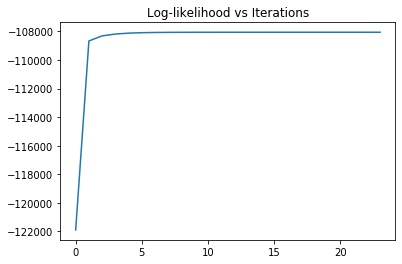

In [6]:
#calculate the optimal cluster paramters
updated_mean,updated_covar,updated_weights = train_GMM(data,K,mean,covar,weights)
np.save('yellow_means.npy',updated_mean)
np.save('yellow_covar.npy',updated_covar)
np.save('yellow_weights.npy',updated_weights)
print("updated parameters=",updated_mean,updated_covar,updated_weights)

In [7]:
#read the video
cap = cv2.VideoCapture("detectbuoy.avi")
images = []
prev_cnts = 0
while (cap.isOpened()):
    #check if frame read is true
    ret, frame = cap.read()
    if ret == False:
        print("Exit!")
        cv2.destroyAllWindows()
        break    
    
    curr_image = frame
    img_x = curr_image.shape[0]
    img_y = curr_image.shape[1]
    image_1 = curr_image[:,:,1].ravel()
    image_2 = curr_image[:,:,2].ravel()
    image = np.concatenate((image_1,image_2),axis=0)
    img = np.reshape(image,(image.shape[0],1))
    prob = np.zeros((img.shape[0],K))
    likelihood = np.zeros((img.shape[0],K))
    for j in range(K):
        #calculate the likelihood
        prob[:,j] = updated_weights[j]*multivariate_normal.pdf(img,updated_mean[j],updated_covar[j])
        likelihood = prob.sum(1)
    #calculate the prob sum which is a 1d array
    sum_prob = np.sum(prob, axis = 1)
    green_prob = sum_prob[:img_x*img_y]
    red_prob = sum_prob[img_x*img_y:]    
    combined_prob = np.add(green_prob,red_prob)    
    combined_prob[red_prob>np.max(red_prob)/1.2] = 255
    output = np.zeros_like(frame)
    pixel_prob =  np.reshape(combined_prob,(img_x,img_y))
    #Assign the calulated probablities to every pixel in the red channel and green channel
    output[:,:,2]= pixel_prob
    output[:,:,1]= pixel_prob
    #blur = cv2.GaussianBlur(output,(5,5),0)
    #Do filtering and edge detection to detect the buoys
    blur = cv2.medianBlur(output,5)
    edged = cv2.Canny(blur,20,255 )
    cv2.imshow("Edge detection- Canny",edged)
    #Detect contours with circle shape
    cnts,h = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    try:  
        (cnts_sorted, boundingBoxes) = contours.sort_contours(cnts)
        prev_cnts = cnts
    except:
        (cnts_sorted, boundingBoxes) = contours.sort_contours(prev_cnts)
    hull = cv2.convexHull(cnts_sorted[0])
    (x,y),radius = cv2.minEnclosingCircle(hull)
    #if greater than a threshold radius, display the detected buoy
    if radius > 5:
        #draw circle over the buoy
        cv2.circle(curr_image,(int(x),int(y)),int(radius+3),(0,200,255),8)
        reshaped = cv2.resize(curr_image,(640,480),interpolation=cv2.INTER_LINEAR)
        cv2.imshow("Yellow detected",reshaped)
        images.append(reshaped)
    else:
        reshaped = cv2.resize(curr_image,(640,480),interpolation=cv2.INTER_LINEAR)
        cv2.imshow("Yellow detected",reshaped)
        images.append(reshaped)
   
    if cv2.waitKey(10) == 27:
        cv2.destroyAllWindows()# exit if Escape is hit
        break

#Save the video file in .avi
out = cv2.VideoWriter('Yellow_1D.avi', cv2.VideoWriter_fourcc(*'XVID'), 5.0, (640, 480))
for image in images:
    out.write(image)
    cv2.waitKey(10)


out.release()
    
cap.release()   

Exit!
